## Imports

In [3]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset
from torchsummary import summary

from PIL import Image
import numpy as np
import os

In [4]:
torch.__version__

'2.8.0'

## Load Images

In [5]:
# Load an image
img = Image.open('/Users/shrutroup/git_repos/machine-learning-zoomcamp/08-deep-learning/data/train/curly/tumblr_nhgozgJrHm1rvhtmyo1_500.jpg')

# Resize to target size
img = img.resize((224, 224))
img.show()

# Convert to numpy array
x = np.array(img)
print(x.shape)  # (224, 224, 3)

(224, 224, 3)


In [6]:
class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


## Preprocessing

In [7]:
from torchvision import transforms

input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Create Data Loaders

In [8]:
from torch.utils.data import DataLoader

train_dataset = HairDataset(
    data_dir='./data/train',
    transform=train_transforms
)

val_dataset = HairDataset(
    data_dir='./data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
print(train_loader.dataset.classes)
print(val_loader.dataset.classes)

['curly', 'straight']
['curly', 'straight']


In [10]:
train_dataset[0]

(tensor([[[-0.6281, -0.3883, -0.1999,  ..., -1.7583, -1.2445, -0.7308],
          [-0.3541, -0.2513, -0.1828,  ..., -1.8268, -1.2788, -0.7479],
          [-0.2171, -0.1999, -0.2171,  ..., -1.7583, -1.3130, -0.7479],
          ...,
          [ 1.6838,  1.7009,  1.5297,  ...,  0.2111,  0.2967,  0.9817],
          [ 1.6838,  1.6495,  1.5468,  ..., -0.4739,  0.6563,  1.3070],
          [ 1.7352,  1.5982,  1.4440,  ..., -0.9192,  0.0056,  1.1529]],
 
         [[ 0.3978,  0.5553,  0.6954,  ..., -0.9328, -0.3725,  0.2052],
          [ 0.5728,  0.6604,  0.7129,  ..., -1.0028, -0.3901,  0.1877],
          [ 0.6954,  0.6954,  0.6954,  ..., -0.9678, -0.4076,  0.2052],
          ...,
          [ 2.0084,  2.0259,  1.8683,  ...,  0.6779,  0.8704,  1.6408],
          [ 2.0084,  1.9734,  1.8683,  ..., -0.0749,  1.2731,  1.9209],
          [ 2.0784,  1.9209,  1.8158,  ..., -0.5826,  0.6078,  1.7633]],
 
         [[ 0.7054,  0.8622,  1.0365,  ..., -0.7413, -0.1138,  0.5834],
          [ 0.8971,  0.9842,

## Build The Model

In [9]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.Sequential(
            # After Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
            # Formula: output_size = (input_size - kernel_size + 2*padding) / stride + 1
            # Height/Width: (200 - 3 + 0) / 1 + 1 = 198
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2,2))
        )
        # calculate the flattened size
        self.flatten = torch.nn.Flatten()
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 200, 200)
            dummy_output = self.conv_layers(dummy_input)
            print(f'''
            Size of dummy_output to calculate the flattened size: {dummy_output.shape}, 
            flattened_size: {dummy_output.shape[1] * dummy_output.shape[2] * dummy_output.shape[3]}
            ''')
            flattened_size = self.flatten(dummy_output).shape[1]
        
        # fully connected layers
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=flattened_size, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=1),
        )
           
        

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x


In [10]:
%%time
# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

# Loss function for binary classification
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss

print(model)

num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float() # make the label shape from [32] --> [32, 1]
        optimizer.zero_grad()
        outputs = model(images) # shape [32, 1]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)


    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


            Size of dummy_output to calculate the flattened size: torch.Size([1, 32, 99, 99]), 
            flattened_size: 313632
            
CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=313632, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1/10, Loss: 0.6571, Acc: 0.6255, Val Loss: 0.6216, Val Acc: 0.6567
Epoch 2/10, Loss: 0.5697, Acc: 0.6929, Val Loss: 0.5990, Val Acc: 0.6617
Epoch 3/10, Loss: 0.5531, Acc: 0.7129, Val Loss: 0.5980, Val Acc: 0.6318
Epoch 4/10, Loss: 0.4849, Acc: 0.7541, Val Loss: 0.6246, Val Acc: 0.6517
Epoch 5/10, Loss: 0.5113, Acc: 0.7316, Val Loss: 0.6233, Val Acc: 0.6617
Epoch 6/10, Loss: 0.4456, Acc: 0.7865, Val Loss: 0.6658, Val Acc: 

## Question 2
What's the total number of parameters of the model? 

In [11]:
summary(model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
           Flatten-4               [-1, 313632]               0
            Linear-5                   [-1, 64]      20,072,512
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 23.93
Params size (MB): 76.57
Estimated Total Size (MB): 100.96
----------------------------------------------------------------


## Generators and Training
Use batch size=20

In [25]:
train_loader2 = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader2 = DataLoader(val_dataset, batch_size=20, shuffle=False)


# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

# Loss function for binary classification
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss

print(model)

num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader2:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader2:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")



            Size of dummy_output to calculate the flattened size: torch.Size([1, 32, 99, 99]), 
            flattened_size: 313632
            
CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=313632, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1/10, Loss: 0.7164, Acc: 0.5581, Val Loss: 0.6841, Val Acc: 0.5224
Epoch 2/10, Loss: 0.6646, Acc: 0.6192, Val Loss: 0.6988, Val Acc: 0.5373
Epoch 3/10, Loss: 0.6320, Acc: 0.6305, Val Loss: 0.6190, Val Acc: 0.6517
Epoch 4/10, Loss: 0.6314, Acc: 0.6404, Val Loss: 0.6519, Val Acc: 0.6119
Epoch 5/10, Loss: 0.6219, Acc: 0.6280, Val Loss: 0.6692, Val Acc: 0.6269
Epoch 6/10, Loss: 0.6016, Acc: 0.6604, Val Loss: 0.6046, Val Acc: 

In [26]:
print(f'Median Training Accuracy: {np.median(history['acc'])}')
print(f'Std Dev of training loss: {np.std(history['loss'])}')


Median Training Accuracy: 0.6398252184769039
Std Dev of training loss: 0.039151188112405276


<Axes: >

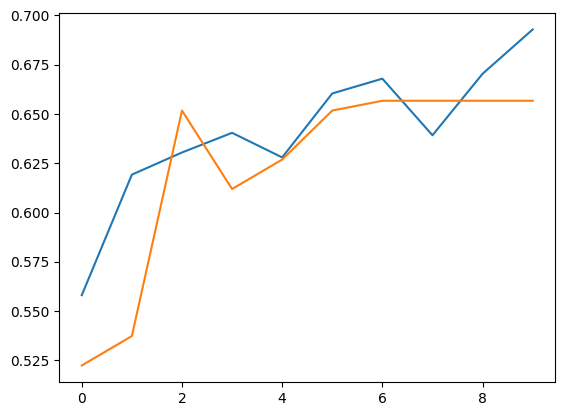

In [27]:
import seaborn as sns
sns.lineplot(history['acc'])
sns.lineplot(history['val_acc'])


## Data Augmentation

In [28]:
input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),      
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = HairDataset(
    data_dir='data/train',
    transform=train_transforms  # Uses augmentation
)

train_loader3 = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader2 = DataLoader(val_dataset, batch_size=20, shuffle=False)


# Continue training for 10 MORE epochs
# DON'T recreate model or optimizer

print("Continuing training for 10 more epochs WITH augmentation...")

num_more_epochs = 10
for epoch in range(num_more_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader3:  # Using NEW augmented data!
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader2:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    # Note: Showing epochs 11-20
    print(f"Epoch {epoch+11}/20, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


Continuing training for 10 more epochs WITH augmentation...
Epoch 11/20, Loss: 0.5687, Acc: 0.6929, Val Loss: 0.5966, Val Acc: 0.6716
Epoch 12/20, Loss: 0.5681, Acc: 0.7004, Val Loss: 0.5856, Val Acc: 0.6667
Epoch 13/20, Loss: 0.5640, Acc: 0.6991, Val Loss: 0.6307, Val Acc: 0.6517
Epoch 14/20, Loss: 0.5745, Acc: 0.6941, Val Loss: 0.5720, Val Acc: 0.6816
Epoch 15/20, Loss: 0.5548, Acc: 0.7116, Val Loss: 0.7179, Val Acc: 0.6318
Epoch 16/20, Loss: 0.5564, Acc: 0.6916, Val Loss: 0.5863, Val Acc: 0.6617
Epoch 17/20, Loss: 0.5558, Acc: 0.6816, Val Loss: 0.5849, Val Acc: 0.6816
Epoch 18/20, Loss: 0.5327, Acc: 0.7079, Val Loss: 0.6581, Val Acc: 0.6418
Epoch 19/20, Loss: 0.5383, Acc: 0.7016, Val Loss: 0.5970, Val Acc: 0.6766
Epoch 20/20, Loss: 0.5272, Acc: 0.7353, Val Loss: 0.6194, Val Acc: 0.6716


In [31]:
np.mean(history['val_loss'])

np.float64(0.6244999002387275)

In [32]:
np.mean(history['val_acc'][15:20])

np.float64(0.6666666666666666)

In [37]:
history['acc']

[0.5580524344569289,
 0.6192259675405742,
 0.630461922596754,
 0.6404494382022472,
 0.6279650436953808,
 0.6604244694132334,
 0.6679151061173533,
 0.6392009987515606,
 0.6704119850187266,
 0.6928838951310862,
 0.6928838951310862,
 0.700374531835206,
 0.6991260923845194,
 0.6941323345817728,
 0.7116104868913857,
 0.6916354556803995,
 0.6816479400749064,
 0.7078651685393258,
 0.7016229712858927,
 0.735330836454432]

<Axes: >

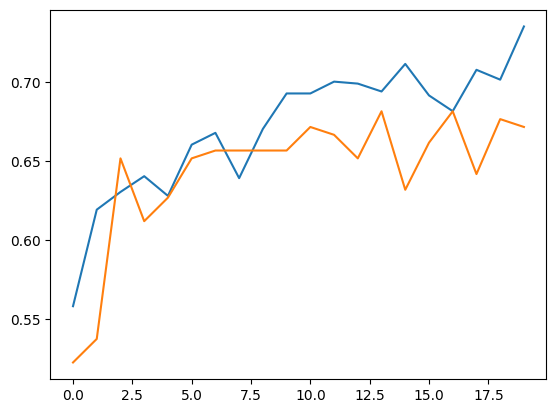

In [ ]:
sns.lineplot(history['acc'])
sns.lineplot(history['val_acc'])


## Implementing Drop Out

In [12]:
class CNN_droput(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        
        self.flatten = torch.nn.Flatten()
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 200, 200)
            dummy_output = self.conv_layers(dummy_input)
            flattened_size = self.flatten(dummy_output).shape[1]
        
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=flattened_size, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=64, out_features=1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [13]:
train_loader2 = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader2 = DataLoader(val_dataset, batch_size=20, shuffle=False)


# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_droput().to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

# Loss function for binary classification
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss

print(model)

num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader2:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader2:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


CNN_droput(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=313632, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1/10, Loss: 0.7246, Acc: 0.5543, Val Loss: 0.6262, Val Acc: 0.6567
Epoch 2/10, Loss: 0.6384, Acc: 0.6604, Val Loss: 0.6021, Val Acc: 0.6468
Epoch 3/10, Loss: 0.6384, Acc: 0.6429, Val Loss: 0.6492, Val Acc: 0.5721
Epoch 4/10, Loss: 0.6218, Acc: 0.6280, Val Loss: 0.6282, Val Acc: 0.6318
Epoch 5/10, Loss: 0.6133, Acc: 0.6292, Val Loss: 0.6057, Val Acc: 0.6617
Epoch 6/10, Loss: 0.5957, Acc: 0.6504, Val Loss: 0.6052, Val Acc: 0.6567
Epoch 7/10, Loss: 0.6043, Acc: 0.6542, Val Loss: 0.6256, Val Acc: 0.6418
Epoch 8/10, Loss: 0.6089, Acc

<Axes: >

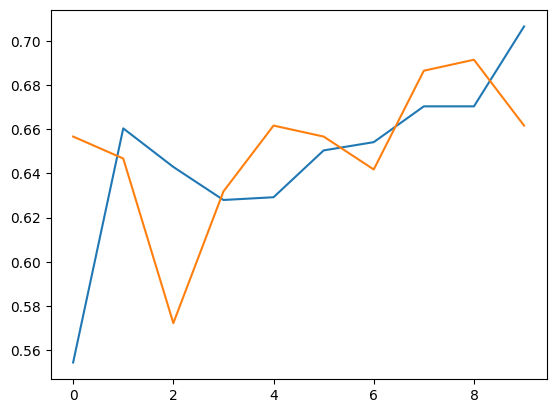

In [15]:
import seaborn as sns
sns.lineplot(history['acc'])
sns.lineplot(history['val_acc'])

In [16]:
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
           Flatten-4               [-1, 313632]               0
            Linear-5                   [-1, 64]      20,072,512
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 23.93
Params size (MB): 76.57
Estimated Total Size (MB): 100.96
----------------------------------------------------------------


## Reduce # of inputs in to the dense layer by adding more CNN layers.

In [19]:
## Reduce # of inputs into the model 
class SmallerCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = torch.nn.Sequential(
            # Block 1
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),  # 200 → 99
            
            # Block 2 (NEW!)
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),  # 99 → 48
            
            # Block 3 (NEW!)
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)  # 48 → 23
        )
        
        self.flatten = torch.nn.Flatten()
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 200, 200)
            dummy_output = self.conv_layers(dummy_input)
            flattened_size = self.flatten(dummy_output).shape[1]
        
        print(f"Flattened size: {flattened_size}")  
        # Should be ~67,712 (128 × 23 × 23) instead of 313,632!
        
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=flattened_size, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=64, out_features=1)
        )

# New model would have:
# Linear: 67,712 × 64 + 64 = 4,333,632 parameters
# Much smaller than 20 million!

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [20]:
train_loader2 = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader2 = DataLoader(val_dataset, batch_size=20, shuffle=False)


# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallerCNN().to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

# Loss function for binary classification
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss

print(model)

num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader2:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) 

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader2:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


Flattened size: 67712
SmallerCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=67712, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1/10, Loss: 0.6869, Acc: 0.5481, Val Loss: 0.6723, Val Acc: 0.5124
Epoch 2/10, Loss: 0.6650, Acc: 0.5905, Val Loss: 0.6461, Val Acc: 0.6318
Epoch 3/10, Loss: 0.6378, Acc: 0.6404, Val Loss: 0.631

Test predictions manually

In [30]:
input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocess = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [34]:
img = Image.open('./data/test/curly/1a9dbe23a0d95f1c292625960e4509184.jpg')
img_t = preprocess(img)
print(img_t.size())
batch_t = torch.unsqueeze(img_t, 0)
print(batch_t.size())

# Make prediction
with torch.no_grad():
    output = model(batch_t)

output.sigmoid().item()
# # Get top predictions
# _, indices = torch.sort(output, descending=True)

torch.Size([3, 200, 200])
torch.Size([1, 3, 200, 200])


0.06354663521051407

In [ ]:
img = Image.open('./data/test/straight/1a9dbe23a0d95f1c292625960e4509184.jpg')
img_t = preprocess(img)
print(img_t.size())
batch_t = torch.unsqueeze(img_t, 0)
print(batch_t.size())

# Make prediction
with torch.no_grad():
    output = model(batch_t)

output.sigmoid().item()

In [38]:
output.argmax()

tensor(0)

In [39]:
output

tensor([[-2.6903]])

In [40]:
model

SmallerCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=67712, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [41]:
train_dataset

In [42]:
train_dataset.class_to_idx

{'curly': 0, 'straight': 1}